# AI Service End-to-End Testing (via API Gateway)

This notebook tests the multi-stage vision analysis pipeline with **real pet images** through the **API Gateway** with authentication.

**Architecture:**
- Requests go through API Gateway (port 8001) with JWT authentication
- API Gateway validates JWT and forwards to AI service (internal port 3003)
- Multi-stage pipeline: Content Safety → Species → Breed → RAG → Ollama

**Prerequisites:**
- All services running: `docker compose ps`
- API Gateway healthy: `curl http://localhost:8001/health`
- **Test user credentials** (will login to get JWT)
- **Test images:** Place pet images in `test_data/images/` directory

In [1]:
import requests
import json
import base64
import os
from pathlib import Path
from io import BytesIO
from PIL import Image
from IPython.display import display, HTML
import pandas as pd

# Configuration
API_GATEWAY_URL = "http://localhost:8001"  # API Gateway (exposed)
TEST_IMAGES_DIR = Path("test_data/images")

# Test user credentials (update these if needed)
TEST_USER_EMAIL = "test_ai@example.com"
TEST_USER_PASSWORD = "testpassword123"

# Session for maintaining cookies
session = requests.Session()

print("✅ Imports loaded successfully")
print(f"🌐 API Gateway: {API_GATEWAY_URL}")
print(f"📁 Test images: {TEST_IMAGES_DIR.absolute()}")

✅ Imports loaded successfully
🌐 API Gateway: http://localhost:8001
📁 Test images: /home/crea/Desktop/ft_transcendence/scripts/jupyter/test_data/images


## 1. Authentication

Login to get JWT access token (stored in HTTP-only cookie).

In [2]:
def login():
    """Login a test user."""
    print("🔐 Logging in test user...")
    
    try:
        response = session.post(
            f"{API_GATEWAY_URL}/api/v1/auth/login",
            json={
                "email": TEST_USER_EMAIL,
                "password": TEST_USER_PASSWORD,
            },
            timeout=10
        )
        
        if response.status_code == 200:
            result = response.json()
            print(f"✅ Login successful")
            print(f"   User: {result.get('data', {}).get('email', 'N/A')}")
            return True
        else:
            print(f"❌ Login failed: {response.status_code}")
            print(f"   Response: {response.text[:200]}")
            return False
            
    except requests.exceptions.ConnectionError:
        print("❌ Cannot connect to API Gateway")
        print("   Make sure services are running: docker compose ps")
        return False
    except Exception as e:
        print(f"❌ Login error: {e}")
        return False

def register():
    """Register a test user."""
    print("📝 Registering test user...")
    
    try:
        response = session.post(
            f"{API_GATEWAY_URL}/api/v1/auth/register",
            json={
                "email": TEST_USER_EMAIL,
                "password": TEST_USER_PASSWORD,
            },
            timeout=10
        )
        
        if response.status_code == 201:
            result = response.json()
            print(f"✅ Registration successful")
            print(f"   User: {result.get('data', {}).get('email', 'N/A')}")
            return True
        elif response.status_code == 409:
            login()
            return True
        else:
            print(f"❌ Registration failed: {response.status_code}")
            print(f"   Response: {response.text[:200]}")
            return False
    except requests.exceptions.ConnectionError:
        print("❌ Cannot connect to API Gateway")
        print("   Make sure services are running: docker compose ps")
        return False
    except Exception as e:
        print(f"❌ Registration error: {e}")
        return False

register()

📝 Registering test user...
✅ Registration successful
   User: N/A


True

## 2. Load Available Test Images

Scan the test data directory for available pet images.

In [3]:
# Supported image formats
IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.webp', '.bmp'}

def find_test_images():
    """Find all image files in the test data directory."""
    if not TEST_IMAGES_DIR.exists():
        print(f"❌ Test images directory not found: {TEST_IMAGES_DIR.absolute()}")
        print("   Create it with: mkdir -p test_data/images")
        return []
    
    images = []
    for ext in IMAGE_EXTENSIONS:
        images.extend(TEST_IMAGES_DIR.glob(f'*{ext}'))
        images.extend(TEST_IMAGES_DIR.glob(f'*{ext.upper()}'))
    
    return sorted(images)

# Find available images
available_images = find_test_images()

if available_images:
    print(f"✅ Found {len(available_images)} test images:")
    for i, img_path in enumerate(available_images, 1):
        file_size = img_path.stat().st_size / 1024  # KB
        print(f"   {i}. {img_path.name} ({file_size:.1f} KB)")
else:
    print("⚠️  No test images found!")
    print(f"\n📝 Please add pet images to: {TEST_IMAGES_DIR.absolute()}")
    print("   Supported formats: JPG, JPEG, PNG, WEBP, BMP")
    print("\n   Example:")
    print("   cp /path/to/dog_photo.jpg test_data/images/")
    print("   cp /path/to/cat_photo.png test_data/images/")

✅ Found 1 test images:
   1. micio_1.jpeg (175.4 KB)


## 3. Helper Functions

Functions to load images and convert to base64.

In [4]:
def load_image_as_base64(image_path):
    """Load image file and convert to base64 data URI."""
    with open(image_path, 'rb') as f:
        image_data = f.read()
    
    # Detect format from file extension
    ext = image_path.suffix.lower().lstrip('.')
    if ext == 'jpg':
        ext = 'jpeg'
    
    encoded = base64.b64encode(image_data).decode()
    return f"data:image/{ext};base64,{encoded}"

def display_image(image_path, max_width=400):
    """Display image with optional max width."""
    img = Image.open(image_path)
    
    # Resize if too large
    if img.width > max_width:
        ratio = max_width / img.width
        new_size = (max_width, int(img.height * ratio))
        img = img.resize(new_size, Image.Resampling.LANCZOS)
    
    print(f"📸 Image: {image_path.name}")
    print(f"   Size: {img.width}x{img.height}")
    display(img)

print("✅ Helper functions loaded")

✅ Helper functions loaded


## 4. Select and Display Test Image

Choose an image to analyze.


🎯 Selected image: micio_1.jpeg

📸 Image: micio_1.jpeg
   Size: 400x533


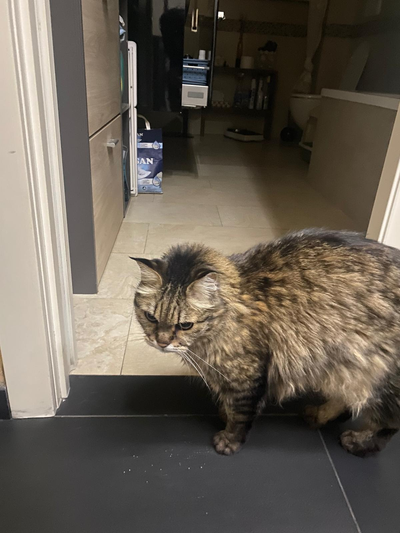


✅ Image encoded: 239499 bytes


In [5]:
if not available_images:
    print("❌ No images available. Please add images to test_data/images/ directory.")
    raise SystemExit("No test images found")

# Change this to test different images (0-indexed)
IMAGE_INDEX = 0

if IMAGE_INDEX >= len(available_images):
    print(f"⚠️  Image index {IMAGE_INDEX} out of range. Using first image.")
    IMAGE_INDEX = 0

selected_image_path = available_images[IMAGE_INDEX]
print(f"\n🎯 Selected image: {selected_image_path.name}\n")

# Display the selected image
display_image(selected_image_path)

# Convert to base64
test_image = load_image_as_base64(selected_image_path)
print(f"\n✅ Image encoded: {len(test_image)} bytes")

## Test Full Vision Analysis Pipeline (via API Gateway)

Send authenticated request through API Gateway.

In [6]:
print("🚀 Sending authenticated request to API Gateway...\n")

try:
    response = session.post(
        f"{API_GATEWAY_URL}/api/v1/vision/analyze",
        json={"image": test_image},
        timeout=60
    )
    
    print(f"✅ Response received")
    print(f"   Status Code: {response.status_code}")
    print(f"   Response Time: {response.elapsed.total_seconds():.2f}s")
    
    result = response.json()
    
except requests.exceptions.ConnectionError:
    print("❌ Connection failed. Make sure API Gateway is running:")
    print("   docker compose ps api-gateway")
    raise
except requests.exceptions.Timeout:
    print("❌ Request timeout. Pipeline may be overloaded or Ollama is slow.")
    raise

# Show raw response for debugging
print(f"\n📄 Raw Response:")
print(json.dumps(result, indent=2)[:10000] + "..." if len(json.dumps(result)) > 10000 else json.dumps(result, indent=2))

🚀 Sending authenticated request to API Gateway...



✅ Response received
   Status Code: 200
   Response Time: 14.27s

📄 Raw Response:
{
  "success": true,
  "data": {
    "species": "cat",
    "breed_analysis": {
      "primary_breed": "maine_coon",
      "confidence": 0.61,
      "is_likely_crossbreed": false,
      "breed_probabilities": [
        {
          "breed": "maine_coon",
          "probability": 0.61
        },
        {
          "breed": "domestic_long_hair",
          "probability": 0.12
        },
        {
          "breed": "domestic_medium_hair",
          "probability": 0.05
        },
        {
          "breed": "persian",
          "probability": 0.03
        },
        {
          "breed": "turkish_angora",
          "probability": 0.03
        }
      ],
      "crossbreed_analysis": null
    },
    "description": "A cat with a thick, well-groomed coat featuring a mix of brown, black, and gray tabby patterns. The body is solid and well-proportioned, neither underweight nor overweight. It stands on a dark floor, 

## 6. Parse and Display Results

Extract and format the pipeline analysis results.

In [7]:
def format_percentage(value):
    """Format float as percentage."""
    return f"{value * 100:.1f}%"

def display_results(result):
    """Display formatted analysis results."""
    # Check if response has 'detail' wrapper (FastAPI HTTPException format)
    if 'detail' in result and isinstance(result['detail'], dict):
        result = result['detail']
    
    if not result.get('success'):
        print("\n" + "="*60)
        print("❌ ANALYSIS FAILED")
        print("="*60)
        error = result.get('error', {})
        print(f"\nError Code: {error.get('code', 'UNKNOWN')}")
        print(f"Message: {error.get('message', 'No details available')}")
        return
    
    data = result['data']
    
    print("\n" + "="*60)
    print("🐕 VISION ANALYSIS RESULTS")
    print("="*60)
    
    # Species
    print(f"\n📊 Species Detection")
    print(f"   Detected: {data['species'].upper()}")
    
    # Breed Analysis
    breed = data['breed_analysis']
    print(f"\n🐾 Breed Analysis")
    print(f"   Primary Breed: {breed['primary_breed'].replace('_', ' ').title()}")
    print(f"   Confidence: {format_percentage(breed['confidence'])}")
    print(f"   Crossbreed: {'Yes' if breed['is_likely_crossbreed'] else 'No'}")
    
    # Breed probabilities
    if breed['breed_probabilities']:
        print(f"\n   📈 Top Breed Probabilities:")
        for i, bp in enumerate(breed['breed_probabilities'][:5], 1):
            breed_name = bp['breed'].replace('_', ' ').title()
            prob = format_percentage(bp['probability'])
            bar = '█' * int(bp['probability'] * 20)
            print(f"      {i}. {breed_name:25s} {prob:>6s} {bar}")
    
    # Crossbreed info
    if breed['crossbreed_analysis']:
        cross = breed['crossbreed_analysis']
        print(f"\n   🔀 Crossbreed Details:")
        print(f"      Common Name: {cross.get('common_name', 'Unknown')}")
        print(f"      Parent Breeds: {', '.join(cross['detected_breeds'])}")
        print(f"      Reasoning: {cross['confidence_reasoning']}")
    
    # Visual Description
    print(f"\n👁️  Visual Description")
    print(f"   {data['description']}")
    
    # Traits
    traits = data['traits']
    print(f"\n🎯 Traits")
    print(f"   Size: {traits['size'].capitalize()}")
    print(f"   Energy Level: {traits['energy_level'].capitalize()}")
    print(f"   Temperament: {traits['temperament']}")
    
    # Health Observations
    print(f"\n💊 Health Observations")
    if data['health_observations']:
        for i, obs in enumerate(data['health_observations'], 1):
            print(f"   {i}. {obs}")
    else:
        print("   ✓ No notable health observations")
    
    # RAG Enrichment
    if data.get('enriched_info'):
        enriched = data['enriched_info']
        print(f"\n📚 Knowledge Base Enrichment")
        
        if enriched.get('breed'):
            print(f"   Breed: {enriched['breed']}")
        
        if enriched.get('parent_breeds'):
            print(f"   Parent Breeds: {', '.join(enriched['parent_breeds'])}")
        
        if enriched.get('description'):
            print(f"\n   ℹ️  Breed Information:")
            desc = enriched['description']
            print(f"      {desc[:200]}..." if len(desc) > 200 else f"      {desc}")
        
        if enriched.get('care_summary'):
            print(f"\n   🏥 Care Requirements:")
            care = enriched['care_summary']
            print(f"      {care[:150]}..." if len(care) > 150 else f"      {care}")
        
        if enriched.get('health_info'):
            print(f"\n   ⚕️  Health Considerations:")
            health = enriched['health_info']
            print(f"      {health[:150]}..." if len(health) > 150 else f"      {health}")
        
        if enriched.get('sources'):
            print(f"\n   📖 Sources: {', '.join(enriched['sources'])}")
    else:
        print(f"\n⚠️  RAG enrichment unavailable (graceful degradation)")
    
    print("\n" + "="*60)
    print(f"\n✅ Analysis complete for: {selected_image_path.name}")

# Display results
display_results(result)


🐕 VISION ANALYSIS RESULTS

📊 Species Detection
   Detected: CAT

🐾 Breed Analysis
   Primary Breed: Maine Coon
   Confidence: 61.0%
   Crossbreed: No

   📈 Top Breed Probabilities:
      1. Maine Coon                 61.0% ████████████
      2. Domestic Long Hair         12.0% ██
      3. Domestic Medium Hair        5.0% █
      4. Persian                     3.0% 
      5. Turkish Angora              3.0% 

👁️  Visual Description
   A cat with a thick, well-groomed coat featuring a mix of brown, black, and gray tabby patterns. The body is solid and well-proportioned, neither underweight nor overweight. It stands on a dark floor, looking downward with a neutral expression. Visible features include upright ears, a prominent nose, and a fluffy tail (partially visible).

🎯 Traits
   Size: Large
   Energy Level: Low
   Temperament: calm and focused, with a neutral facial expression

💊 Health Observations
   1. coat appears healthy with no visible mats or skin issues
   2. eyes are clear w

## Cleanup

In [8]:
response = session.delete(
    f"{API_GATEWAY_URL}/api/v1/auth/delete"
)
print(response)

<Response [200]>


## Summary

This notebook demonstrates:
- ✅ **Authentication** through API Gateway with JWT cookies
- ✅ **Secure access** to AI service via API Gateway (backend service isolation)
- ✅ Loading real pet images from test data directory
- ✅ Multi-stage pipeline execution
- ✅ Species and breed classification
- ✅ Crossbreed detection
- ✅ RAG enrichment with breed knowledge
- ✅ Contextual visual analysis
- ✅ Service health monitoring

**Architecture Benefits:**
- 🔒 Backend services protected (not exposed to localhost)
- 🔐 JWT authentication enforced
- ⚡ Rate limiting applied (60 req/min per user)
- 🛡️ Security boundaries maintained

**Next Steps:**
- Add more test images to `test_data/images/`
- Test with different user accounts
- Monitor rate limiting behavior
- Test edge cases (blurry images, multiple pets, etc.)